In [1]:
import bempp.api
import numpy as np

Crear malla

In [4]:
grid = bempp.api.shapes.sphere(h=0.1)
#grid.plot()

In [6]:
grid.vertices

array([[ 1.        ,  0.        , -1.        , ...,  0.1547311 ,
         0.91767718,  0.058614  ],
       [ 0.        ,  1.        ,  0.        , ..., -0.22197253,
        -0.32872529, -0.05924478],
       [ 0.        ,  0.        ,  0.        , ..., -0.96270327,
        -0.22323286, -0.99652132]])

Definir espacios

Usar p1 en todos

In [26]:
dp0_space = bempp.api.function_space(grid, "DP", 0)
p1_space = bempp.api.function_space(grid, "P", 1)

Define potenciales (no es necesario)

In [27]:
identity = bempp.api.operators.boundary.sparse.identity(
    p1_space, p1_space, dp0_space)
dlp = bempp.api.operators.boundary.laplace.double_layer(
    p1_space, p1_space, dp0_space)
slp = bempp.api.operators.boundary.laplace.single_layer(
    dp0_space, p1_space, dp0_space)

Definir valor en la frontera 
Este valor será el entregado por la NN

In [64]:
@bempp.api.real_callable
def dirichlet_data(x, n, domain_index, result):
    result[0] = 1./(4 * np.pi * ((x[0]+0.9)**2 + x[1]**2 + x[2]**2)**(0.5))
    
dirichlet_fun = bempp.api.GridFunction(p1_space, fun=dirichlet_data)

Solver (no es necesario)

In [65]:
rhs = (.5 * identity + dlp) * dirichlet_fun 

In [70]:
neumann_fun, info = bempp.api.linalg.cg(slp, rhs, tol=1E-4)

In [71]:
n_grid_points = 150
plot_grid = np.mgrid[-1:1:n_grid_points*1j, -1:1:n_grid_points*1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

Se calcula función en puntos definidos

* NN entrega:
    + dirichlet_fun
    + neumann_fun   
.
* Points se define como uno quiera:
    - Entrenamiento: Borde
    - Estimación: Todo el dominio


Se utiliza el espacio de funciones??

slp_pot y dlp_pot se definen solo 1 vez!

pq se usa grid y nuevos puntos??

In [72]:
slp_pot = bempp.api.operators.potential.laplace.single_layer(
    dp0_space, points)
dlp_pot = bempp.api.operators.potential.laplace.double_layer(
    p1_space, points)
u_evaluated = slp_pot * neumann_fun - dlp_pot * dirichlet_fun

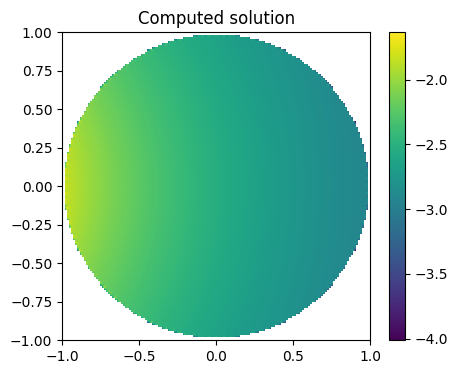

In [73]:
# The next command ensures that plots are shown within the IPython notebook
%matplotlib inline

# Filter out solution values that are associated with points outside the unit circle.
u_evaluated = u_evaluated.reshape((n_grid_points,n_grid_points))
radius = np.sqrt(plot_grid[0]**2 + plot_grid[1]**2)
u_evaluated[radius>1] = np.nan

# Plot the image
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5.0, 4.0)

from matplotlib import pylab as plt

plt.imshow(np.log(np.abs(u_evaluated.T)), extent=(-1,1,-1,1))
plt.title('Computed solution')
plt.colorbar()

In [75]:
help(grid)

Help on Grid in module bempp.api.grid.grid object:

class Grid(builtins.object)
 |  Grid(vertices, elements, domain_indices=None, grid_id=None, scatter=True)
 |  
 |  The Grid class.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, vertices, elements, domain_indices=None, grid_id=None, scatter=True)
 |      Create a grid from a vertices and an elements array.
 |  
 |  data(self, precision='double')
 |      Return Numba container with all relevant grid data.
 |  
 |  entity_count(self, codim)
 |      Return the number of entities of given codimension.
 |  
 |  entity_iterator(self, codim)
 |      Return an iterator for a given codim.
 |  
 |  get_element(self, index)
 |      Return element with a given index.
 |  
 |  map_to_point_cloud(self, order=None, local_points=None, precision='double')
 |      Return a point cloud representation of the grid on quadratur points.
 |      
 |      Return a representation of the grid as a point cloud using points on
 |      each element either 

In [77]:
grid.get_element(1)